# Overview
This notebook downloads results of 25 runs of ProteinCartography for a representative sample of top-studied human proteins and performs a meta-analysis of the results to identify the boundaries of the pipeline's functionalities.

The Zenodo DOI containing the data is here:  
[![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.8377393.svg)](https://doi.org/10.5281/zenodo.8377393)

## `conda` environment

You can install the `conda` environment needed to run this notebook by running the following command from the within the `ProteinCartography` repo:

```bash
conda env create -f envs/cartography_pub.yml -n cartography_pub
conda activate cartograph_pub
```

# 0. Setup

Import dependencies for downloading, analyses, and plotting.  
Use `requests` to download and unpack a zipped file from Zenodo which contains all of the results.

In [1]:
#######################
# Import dependencies #
#######################
import os
import pandas as pd
import numpy as np
import matplotlib.colors as mc
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import zipfile
import io

##################################
# Load Arcadia-specific packages #
##################################
import sys

# set up specialized functions
sys.path.append('../ProteinCartography/')
from plot_interactive import assign_taxon, EUK_COLOR_DICT

# set up colors and plot scheme
import arcadia_pycolor as apc
apc.mpl_setup()

########################
# Set global variables #
########################
data_dir = '25humanprotein_analysis'

# download analysis results files if they don't already exist
if not os.path.exists(data_dir):
    url = "https://zenodo.org/record/8377393/files/25humanprotein_analysis.zip?download=1"
    output_file = "25humanprotein_analysis.zip"

    chunk_size = 1024 * 1024

    # Download the ZIP file using streaming
    with requests.get(url, stream=True) as response:
        if response.status_code == 200:
            with open(output_file, 'wb') as file:
                for chunk in response.iter_content(chunk_size=chunk_size):
                    if chunk:
                        file.write(chunk)
            print(f"File downloaded as {output_file}")
            
            # Unzip the file using streaming
            with zipfile.ZipFile(output_file, 'r') as zip_ref:
                zip_ref.extractall(data_dir)
            print(f"File contents extracted to {data_dir}")
        else:
            print(f"Failed to download file. Status code: {response.status_code}")

output_dir = 'pub_cluster_quality'

# create output directory if it doesn't already exist
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

# 1. Prepare identifier mapping dictionaries

The following dictionaries are used to map the folder names to gene identifiers, and gene identifiers to UniProt IDs.

In [2]:
# set names of results folders
results_folders = {
    'alktyrosinekinasereceptor': 'ALK',
    'bileacidreceptor': 'NR1H4',
    'cathepsink': 'CATK',
    'complementfactorh': 'CFAH',
    'dihydrofolatereductase': 'DYR',
    'e3ubiquitinproteinligasexiap1': 'XIAP',
    'glycogensynthasekinase3beta': 'GSK3B',
    'gtpasehras': 'RASH',
    'hemoglobinsubunitbeta': 'HBB',
    'hlaclassihistocompatibilityantigenaalphachain': 'HLAA',
    'immunoglobulinkappaconstant': 'IGKC',
    'macrophagemigrationinhibitoryfactor': 'MIF',
    'mitogenactivatedproteinkinase10': 'MK10',
    'nuclearreceptorcoactivator2': 'NCOA2',
    'parkinsondiseaseprotein7': 'PARK7',
    'peptidylprolylcistransisomerasea': 'PPIA',
    'peptidylprolylcistransisomerasefkbp5': 'FKBP5',
    'phosphatidylinositol3kinaseregulatorysubunitalpha': 'P85A',
    'polycombproteineed': 'EED',
    'proteasomesubunitbetatype5': 'PSB5',
    'retinoicacidreceptorrxralpha': 'RXRA',
    'retinolbindingprotein2': 'RET2',
    'superoxidedisumutase': 'SODC',
    'ubiquitincarboxylterminalhydrolase7': 'UBP7',
    'vonhippelailindaudiseasetumorsuppressor': 'VHL'
}

results_folders_r = {v: k for k, v in results_folders.items()}

protids_dict = {
    'ALK': 'Q9UM73',
    'NR1H4': 'Q96RI1',
    'CATK': 'P43235',
    'CFAH': 'P08603',
    'DYR': 'P00374',
    'XIAP': 'P98170',
    'GSK3B': 'P49841',
    'RASH': 'P01112',
    'HBB': 'P68871',
    'HLAA': 'P04439',
    'IGKC': 'P01834',
    'MIF': 'P14174',
    'MK10': 'P53779',
    'NCOA2': 'Q15596',
    'PARK7': 'Q99497',
    'PPIA': 'P62937',
    'FKBP5': 'Q13451',
    'P85A': 'P27986',
    'EED': 'O75530',
    'PSB5': 'P28074',
    'RXRA': 'P19793',
    'RET2': 'P50120',
    'SODC': 'P00441',
    'UBP7': 'Q93009',
    'VHL': 'P40337',
}

# 2. Calculate cluster compactness and number of clusters for Leiden and structural clusters

Here, we extract the similarity matrix files from each analysis and calculate the mean along the diagonal as a measure of "cluster compactness". The similarity matrix is calculated by taking averaging the TM-scores of each protein in each cluster against every protein in each other cluster.

In [3]:
# generate a file prefix for each results folder
simm_files_prefix = [os.path.join(data_dir, folder, 'output', 'clusteringresults', f'{folder.split("_")[0]}') for folder in results_folders]

# collector lists
leiden_diag_means = []
leiden_nclust = []
sc_diag_means = []
sc_nclust = []

# list of results folders that were skipped (should be empty)
skipped = []

# iterate through each results folder
for i, pre in enumerate(simm_files_prefix):

    # collect skipped folders
    if not os.path.exists(f'{pre}_leiden_similarity.tsv') or not os.path.exists(f'{pre}_strucluster_similarity.tsv'):
        skipped.append(list(results_folders.keys())[i])
        continue
    
    # calculate mean along the diagonal of the Leiden cluster similarity matrix
    leiden_df = pd.read_csv(f'{pre}_leiden_similarity.tsv', sep = '\t', index_col = 'LeidenCluster')
    leiden_diag = np.diagonal(leiden_df)
    leiden_diag_mean = np.mean(leiden_diag)
    
    # record means and number of clusters
    leiden_nclust.append(len(leiden_diag))
    leiden_diag_means.append(leiden_diag_mean)
    
    # calculate mean along the diagonal of the structural cluster similarity matrix
    sc_df = pd.read_csv(f'{pre}_strucluster_similarity.tsv', sep = '\t', index_col = 'StruCluster')
    sc_diag = np.diagonal(sc_df)
    sc_diag_mean = np.mean(sc_diag)
    
    # record means and number of clusters    
    sc_nclust.append(len(sc_diag))
    sc_diag_means.append(sc_diag_mean)

# list folders that were not skipped
not_skipped = [results_folders[i] for i in results_folders if i not in skipped]

#  build dataframes for each metric
means_df = pd.DataFrame({'Leiden': leiden_diag_means, 'Structural': sc_diag_means}, index = not_skipped)
nclust_df = pd.DataFrame({'Leiden': leiden_nclust, 'Structural': sc_nclust}, index = not_skipped)

# load in sampled data with metadata
sampled_df = pd.read_csv('sampled_proteins.tsv', sep = '\t', index_col = 0)

# join dataframes
metrics_df = means_df.join(nclust_df, lsuffix = '_mean', rsuffix = '_count')
# make a copy for heatmap plotting
heatmap_df = metrics_df.copy(deep = True)

# generate dataframe that aggregates identifiers and heatmap info
protids_df = pd.DataFrame({'protid': protids_dict.values()}, index = protids_dict.keys())
metrics_df = metrics_df.join(protids_df)
metrics_df = metrics_df.reset_index().rename(columns = {'index': 'gene'})

# add metadata to heatmap dataframe
metrics_df = metrics_df.merge(sampled_df, left_on = 'protid', right_on = 'protid')

# save results
most_studied_proteins_df = pd.read_csv('most_studied_human_proteins_analysis.tsv', sep = '\t', index_col = 0)

# add metadata to most studied proteins dataframe
metrics_df = pd.concat([metrics_df, most_studied_proteins_df])
metrics_df.to_csv('most_studied_human_proteins_metadata.tsv', sep = '\t', index = None)

display(metrics_df)

,gene,Leiden_mean,Structural_mean,Leiden_count,Structural_count,protid,protein,Length,pdb_origin,pdb_confidence,pdb_chains,Length_bin,pdb_confidence_bin,combined,combined_weight,sampled
0,ALK,0.456356,0.460576,9.0,2.0,Q9UM73,ALK tyrosine kinase receptor,1620,AlphaFold,67.276466,['A'],10,1,"(10, 1)",0.037433,NaN
1,NR1H4,0.607804,0.478895,11.0,1.0,Q96RI1,Bile acid receptor,486,AlphaFold,69.765294,['A'],6,2,"(6, 2)",0.010695,NaN
2,CATK,0.778683,0.484278,15.0,3.0,P43235,Cathepsin K,329,AlphaFold,95.094008,['A'],4,9,"(4, 9)",0.026738,NaN
3,CFAH,0.554578,0.379805,14.0,1.0,P08603,Complement factor H,1231,AlphaFold,79.112146,['A'],10,3,"(10, 3)",0.032086,NaN
4,DYR,0.841025,0.549339,12.0,2.0,P00374,Dihydrofolate reductase,187,AlphaFold,96.339755,['A'],2,10,"(2, 10)",0.037433,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182,NaN,NaN,NaN,NaN,NaN,P18031,Tyrosine-protein phosphatase non-receptor type 1,435,AlphaFold,82.030609,['A'],6,3,"(6, 3)",0.026738,no
183,NaN,NaN,NaN,NaN,NaN,P29373,Cellular retinoic acid-binding protein 2,138,AlphaFold,96.710100,['A'],1,10,"(1, 10)",0.026738,no
184,NaN,NaN,NaN,NaN,NaN,P0DP23,Calmodulin-1,149,AlphaFold,85.087947,['A'],2,5,"(2, 5)",0.005348,no
185,NaN,NaN,NaN,NaN,NaN,P25788,Proteasome subunit alpha type-3,255,AlphaFold,94.693955,['A'],3,9,"(3, 9)",0.021390,no


# 3. Generate heatmap

We sort the values of the heatmap based on the cluster compactness (`Leiden_mean`) for consistency throughout the pub.

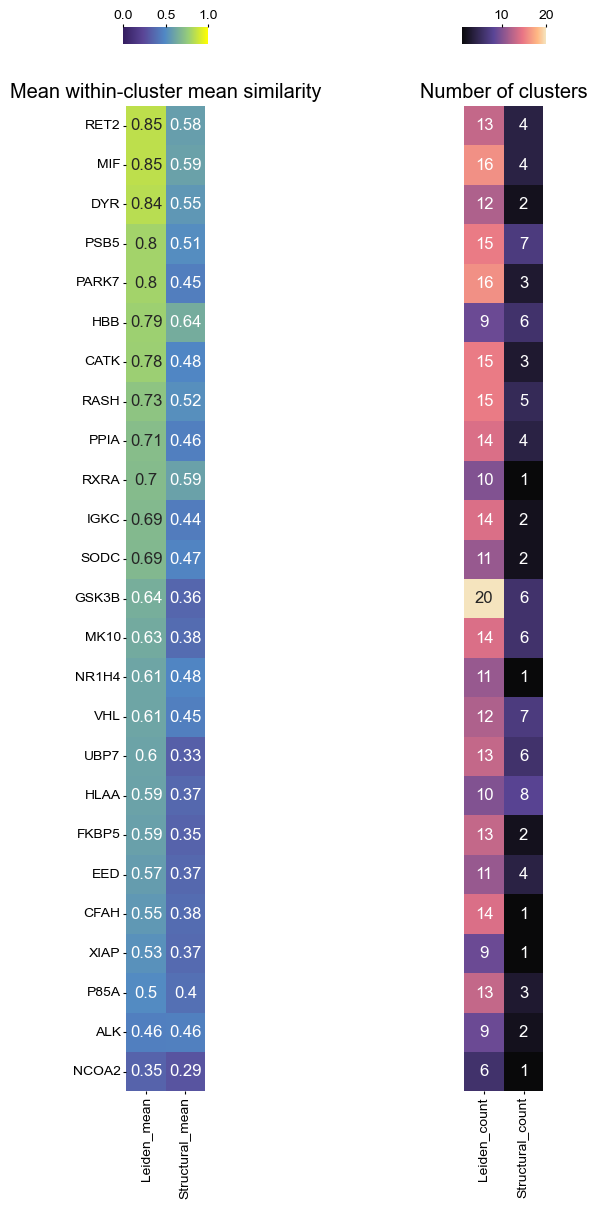

In [4]:
# generate heatmap
heatmap_df.sort_values('Leiden_mean', ascending = False, inplace = True)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (8, 16))
fig.subplots_adjust(wspace=0.2)

sns.heatmap(heatmap_df[['Leiden_mean', 'Structural_mean']], cmap = 'arcadia:viridis', ax = ax1, vmin = 0, vmax = 1, annot = True, square = True, cbar_kws = dict(use_gridspec=False,location="top", shrink = 0.3, aspect = 5))
ax1.title.set_text('Mean within-cluster mean similarity')

sns.heatmap(heatmap_df[['Leiden_count', 'Structural_count']], cmap = 'arcadia:magma', ax = ax2, annot = True, square = True, yticklabels = False, cbar_kws = dict(use_gridspec=False,location="top", shrink = 0.3, aspect = 5))
ax2.title.set_text('Number of clusters')

plt.savefig('cluster_diagonal_comparison_human_proteins_sorted.svg')

# 4. Generate bivariate scatter

Generate scatter plot for pLDDT vs. protein length, masking non-sampled proteins as grey and coloring points my cluster compactness and number of clusters.

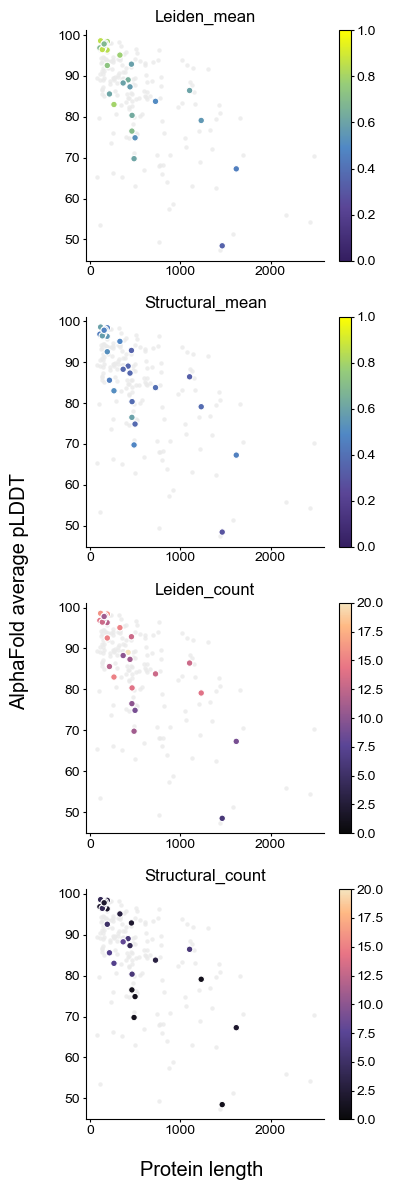

In [5]:
# create figure
fig = plt.figure(figsize = (4, 12))

# load in custom Arcadia color gradients
viridis = apc.Gradients['arcadia:viridis'].mpl_LinearSegmentedColormap
magma = apc.Gradients['arcadia:magma'].mpl_LinearSegmentedColormap

# iterate through each of the four columns
for i, column in enumerate(['Leiden_mean', 'Structural_mean', 'Leiden_count', 'Structural_count']):

    # set color and value range for each column
    if 'mean' in column:
        v = [0, 1]
        cmap = viridis
    elif 'count' in column:
        v = [0, max(max(metrics_df['Leiden_count']), max(metrics_df['Structural_count']))]
        cmap = magma

    # separate selected and not selected proteins
    selected = metrics_df[~metrics_df[column].isna()]
    notselected = metrics_df[metrics_df[column].isna()]
    
    # plot selected and not selected proteins
    plt.subplot(4, 1, i + 1)
    plt.scatter(
        x = notselected['Length'], 
        y = notselected['pdb_confidence'], 
        s = 10, 
        alpha = 0.8, 
        color = 'arcadia:brightgrey',
    )
    sc = plt.scatter(
        x = selected['Length'], 
        y = selected['pdb_confidence'], 
        s = 22, 
        alpha = 1, 
        c = selected[column],
        edgecolors = 'white',
        linewidths = 0.8,
        vmin = v[0],
        vmax = v[1],
        cmap = cmap
    )
    plt.colorbar(sc)
    plt.title(column, fontsize = 12)

# set axis labels
fig.supxlabel('Protein length')
fig.supylabel('AlphaFold average pLDDT')

# set up figure layout
plt.tight_layout()

# save figure
plt.savefig('most_studied_human_proteins_cluster_quality.svg')
plt.show()

# 5. Collect other metadata per analysis

This block of code iterates through and calculates a variety of metrics for each analysis for plotting in a violin plot.

In [6]:
len_df = metrics_df[~metrics_df['gene'].isna()].sort_values('Leiden_mean')

lens = list(len_df['gene'].values)
len_files_prefix = [os.path.join(data_dir, results_folders_r[gene], 'output', 'clusteringresults', f'{results_folders_r[gene].split("_")[0]}') for gene in lens]
blast_files_prefix = [os.path.join(data_dir, results_folders_r[gene], 'output', 'blastresults') for gene in lens]

lengths_list = []
lengths_mean_list = []
lengths_median_list = []

pdb_confidence_list = []
pdb_confidence_mean_list = []
pdb_confidence_median_list = []

ndomains_prot_list = []
ndomains_list = []
ndomains_mean_list = []
ndomains_median_list = []

tmscore_list = []
tmscore_mean_list = []
tmscore_median_list = []

tmscore_fs_list = []
tmscore_fs_mean_list = []
tmscore_fs_median_list = []

tmscore_blast_list = []
tmscore_blast_mean_list = []
tmscore_blast_median_list = []

fident_fs_list = []
fident_fs_mean_list = []
fident_fs_median_list = []

fident_blast_list = []
fident_blast_mean_list = []
fident_blast_median_list = []

counts_list = []
fs_counts_list = []
blast_counts_list = []
nspecies_list = []
taxon_counts_dict = {}

for i, pre in enumerate(len_files_prefix):

    protid = protids_dict[lens[i]]

    agg_df = pd.read_csv(f'{pre}_aggregated_features.tsv', sep = '\t')
    agg_df = agg_df[~agg_df['StruCluster'].isna()]

    counts_list.append(len(agg_df))
    fs_counts_list.append(len(agg_df[agg_df['source.method'].str.contains('foldseek')]))
    blast_counts_list.append(len(agg_df[agg_df['source.method'].str.contains('blast')]))
    nspecies_list.append(len(agg_df['Organism'].unique()))
    
    lengths = agg_df['Length'].astype('int').values
    lengths_list.append(lengths)
    lengths_mean_list.append(np.mean(lengths))
    lengths_median_list.append(np.median(lengths))

    pdb_confidence = agg_df['pdb_confidence'].astype('int').values
    pdb_confidence_list.append(pdb_confidence)
    pdb_confidence_mean_list.append(np.mean(pdb_confidence))
    pdb_confidence_median_list.append(np.median(pdb_confidence))

    tmscores = agg_df[f'TMscore_v_{protid}'].values
    tmscore_list.append(tmscores)

    tmscore_mean_list.append(np.mean(tmscores))
    tmscore_median_list.append(np.median(tmscores))

    tmscore_fs = agg_df[agg_df['source.method'].str.contains('foldseek')][f'TMscore_v_{protid}'].values
    tmscore_fs_list.append(tmscore_fs)
    tmscore_fs_mean_list.append(np.mean(tmscore_fs))
    tmscore_fs_median_list.append(np.median(tmscore_fs))
    
    tmscore_blast = agg_df[agg_df['source.method'].str.contains('blast')][f'TMscore_v_{protid}'].values
    tmscore_blast_list.append(tmscore_blast)
    tmscore_blast_mean_list.append(np.mean(tmscore_blast))
    tmscore_blast_median_list.append(np.median(tmscore_blast))

    fidents_fs = agg_df[f'fident_v_{protid}'].dropna().values
    fident_fs_list.append(fidents_fs)
    fident_fs_mean_list.append(np.mean(fidents_fs))
    fident_fs_median_list.append(np.median(fidents_fs))

    blast_results_df = pd.read_csv(f'{blast_files_prefix[i]}/{protid}.blastresults.tsv', sep = '\t', header = None)
    fidents_blast = blast_results_df[2].values * 0.01
    fident_blast_list.append(fidents_blast)
    fident_blast_mean_list.append(np.mean(fidents_blast))
    fident_blast_median_list.append(np.median(fidents_blast))

    agg_df = pd.read_csv(f'{pre}_aggregated_features.tsv', sep = '\t')
    agg_df = agg_df[~agg_df['StruCluster'].isna()]

    agg_df['Pfam_ndomains'] = agg_df['Pfam'].apply(lambda x: len([i for i in x.split(';') if i != '']) if x is not np.nan else 0)
    ndomains_prot_list.append(list(agg_df[agg_df['protid'] == protids_dict[lens[i]]]['Pfam_ndomains'].values)[0])
    ndomains = agg_df['Pfam_ndomains'].values
    ndomains_list.append(ndomains)
    ndomains_mean_list.append(np.mean(ndomains))
    ndomains_median_list.append(np.median(ndomains))

    agg_df['Broad Taxon'] = agg_df['Lineage'].apply(lambda x: assign_taxon(x, EUK_COLOR_DICT.keys(), hierarchical = True))

    taxon_counts_dict[lens[i]] = agg_df['Broad Taxon'].value_counts()

# 6. Generate violin plot with means

This code block generates a violin plot where a diamond represents the mean value.

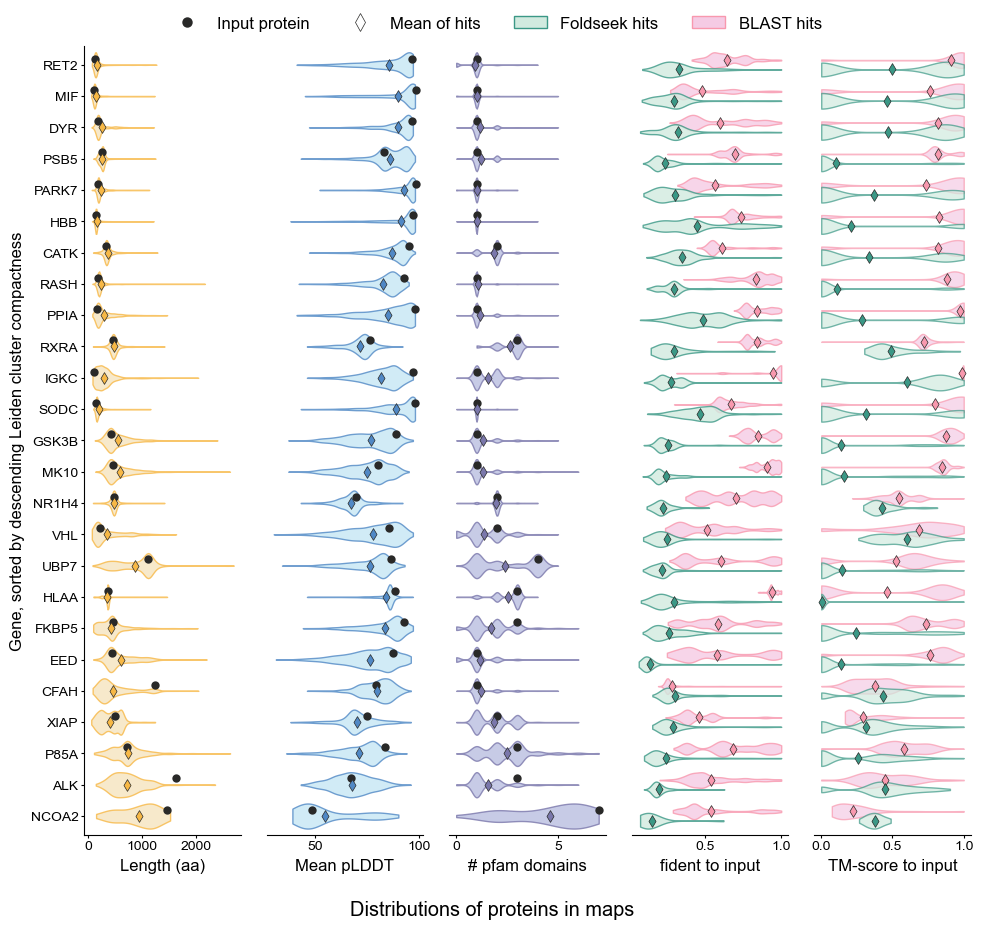

In [7]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows = 1, ncols = 5, figsize = (10, 9))
fig.subplots_adjust(wspace = 0.1)
parts = ax1.violinplot(lengths_list, vert = False, showextrema = False, widths = 0.8)

for pc in parts['bodies']:
    pc.set_facecolor(apc.All['arcadia:oat'])
    pc.set_edgecolor(apc.All['arcadia:canary'])
    pc.set_linewidths(1)
    pc.set_alpha(0.8)

ax1.scatter(x = len_df['Length'].values, y = [i + 1.2 for i in range(len(len_df))], color = 'arcadia:crow')
ax1.scatter(x = lengths_mean_list, y = [i + 1 for i in range(len(len_df))], color = 'arcadia:canary', edgecolor = 'arcadia:crow' , linewidth = 0.5, marker = "d")

ax1.set_yticks([i + 1 for i in range(len(len_df))])
ax1.set_yticklabels(lens)
ax1.set_ylim(0.4, 25.6)
ax1.set_xlabel('Length (aa)')
ax1.set_ylabel('Gene, sorted by descending Leiden cluster compactness')

parts = ax2.violinplot(pdb_confidence_list, vert = False, showextrema = False, widths = 0.8)

for pc in parts['bodies']:
    pc.set_facecolor(apc.All['arcadia:bluesky'])
    pc.set_edgecolor(apc.All['arcadia:aegean'])
    pc.set_linewidths(1)
    pc.set_alpha(0.8)

ax2.scatter(x = len_df['pdb_confidence'].values, y = [i + 1.2 for i in range(len(len_df))], color = 'arcadia:crow')
ax2.scatter(x = pdb_confidence_mean_list, y = [i + 1 for i in range(len(len_df))], color = 'arcadia:aegean', edgecolor = 'arcadia:crow' , linewidth = 0.5, marker = "d")
ax2.set_yticks([])
ax2.spines[['left']].set_visible(False)
ax2.set_ylim(0.4, 25.6)
ax2.set_xlabel('Mean pLDDT')

parts = ax3.violinplot(ndomains_list, vert = False, showextrema = False, widths = 0.8)

for pc in parts['bodies']:
    pc.set_facecolor(apc.All['arcadia:wish'])
    pc.set_edgecolor(apc.All['arcadia:aster'])
    pc.set_linewidths(1)
    pc.set_alpha(0.8)

ax3.scatter(x = ndomains_prot_list, y = [i + 1.2 for i in range(len(len_df))], color = 'arcadia:crow')
ax3.scatter(x = ndomains_mean_list, y = [i + 1 for i in range(len(len_df))], color = 'arcadia:aster', edgecolor = 'arcadia:crow' , linewidth = 0.5, marker = "d")

ax3.set_yticks([])
ax3.spines[['left']].set_visible(False)
ax3.set_ylim(0.4, 25.6)
ax3.set_xlabel('# pfam domains')

######

parts = ax4.violinplot(fident_blast_list, positions = [i + 1.15 for i in range(len(len_df))], vert = False, showextrema = False, widths = 0.5)

for pc in parts['bodies']:
    pc.set_facecolor(apc.All['arcadia:blossom'])
    pc.set_edgecolor(apc.All['arcadia:rose'])
    pc.set_linewidths(1)
    pc.set_alpha(0.8)

parts = ax4.violinplot(fident_fs_list, positions = [i + 0.85 for i in range(len(len_df))], vert = False, showextrema = False, widths = 0.5)

for pc in parts['bodies']:
    pc.set_facecolor(apc.All['arcadia:mint'])
    pc.set_edgecolor(apc.All['arcadia:seaweed'])
    pc.set_linewidths(1)
    pc.set_alpha(0.8)

ax4.scatter(x = fident_blast_mean_list, y = [i + 1.15 for i in range(len(len_df))], color = 'arcadia:rose', edgecolor = 'arcadia:crow', linewidth = 0.5, marker = "d")
ax4.scatter(x = fident_fs_mean_list, y = [i + 0.85 for i in range(len(len_df))], color = 'arcadia:seaweed', edgecolor = 'arcadia:crow', linewidth = 0.5, marker = "d")

ax4.set_yticks([])
ax4.spines[['left']].set_visible(False)
ax4.set_ylim(0.4, 25.6)
ax4.set_xlabel('fident to input')

######

parts = ax5.violinplot(tmscore_blast_list, positions = [i + 1.15 for i in range(len(len_df))], vert = False, showextrema = False, widths = 0.5)

for pc in parts['bodies']:
    pc.set_facecolor(apc.All['arcadia:blossom'])
    pc.set_edgecolor(apc.All['arcadia:rose'])
    pc.set_linewidths(1)
    pc.set_alpha(0.7)
    
parts = ax5.violinplot(tmscore_fs_list,  positions = [i + 0.85 for i in range(len(len_df))], vert = False, showextrema = False, widths = 0.5)

for pc in parts['bodies']:
    pc.set_facecolor(apc.All['arcadia:mint'])
    pc.set_edgecolor(apc.All['arcadia:seaweed'])
    pc.set_linewidths(1)
    pc.set_alpha(0.7)

ax5.scatter(x = tmscore_blast_mean_list, y = [i + 1.15 for i in range(len(len_df))], color = 'arcadia:rose', edgecolor = 'arcadia:crow', linewidth = 0.5, marker = "d")
ax5.scatter(x = tmscore_fs_mean_list, y = [i + 0.85 for i in range(len(len_df))], color = 'arcadia:seaweed', edgecolor = 'arcadia:crow', linewidth = 0.5, marker = "d")
                     
ax5.set_yticks([])
ax5.spines[['left']].set_visible(False)
ax5.set_ylim(0.4, 25.6)
ax5.set_xlabel('TM-score to input')

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

legend_elements = [Line2D([0], [0], marker='.', markerfacecolor='arcadia:crow', markersize=15, linewidth = 0, label='Input protein'),
                   Line2D([0], [0], marker='d', markeredgecolor='arcadia:crow', markersize=9, markeredgewidth = 0.5, markerfacecolor = 'w', linewidth = 0, label='Mean of hits'),
                   Patch(facecolor = 'arcadia:mint', edgecolor='arcadia:seaweed', linewidth = 1, label='Foldseek hits'),
                   Patch(facecolor = 'arcadia:blossom', edgecolor='arcadia:rose', linewidth = 1, label='BLAST hits')]

fig.supxlabel('Distributions of proteins in maps')
plt.tight_layout()

ax3.legend(legend_elements, ['Input protein', 'Mean of hits', 'Foldseek hits', 'BLAST hits'], loc = 'lower center', bbox_to_anchor = (0.3, 1), ncols = len(legend_elements))

plt.savefig('most_studied_proteins_hit_distributions.svg')
plt.show()

# 7. Generate heatmap with pLDDT color scale

This code block generates a heat map where the color is similar along a blue -> cyan -> yellow -> orange -> red colorscale similar to what is used by AlphaFold.

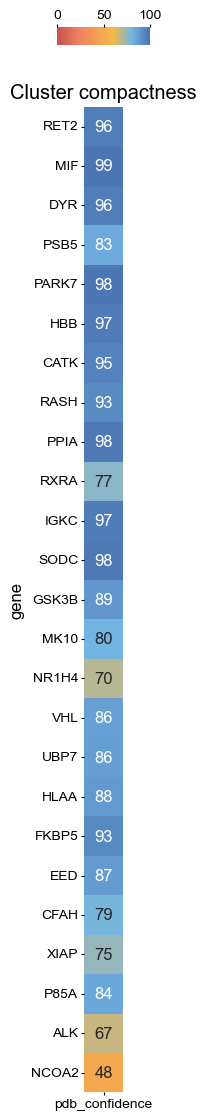

In [8]:
plddt_gradient_dict = {
    'color_dict': apc.dragon | apc.amber | apc.canary | apc.vitalblue | {'arcadia:cobalt': '#4A72B0'},
    'values': [0, 0.25, 0.6, 0.8, 1]
}

# instantiate a new Gradient object
plddt_gradient = apc.Gradient(
    name = 'plddt_gradient',
    color_dict = plddt_gradient_dict['color_dict'], 
    values = plddt_gradient_dict['values']
)

plddt_gradient.mpl_LinearSegmentedColormap_register()

conf_df = metrics_df[~metrics_df['gene'].isna()].sort_values('Leiden_mean', ascending = False)[['pdb_confidence', 'gene']]
conf_df.index = conf_df['gene']
conf_df.drop(columns = ['gene'], inplace = True)

fig = plt.figure(figsize = (4, 16))

ax = sns.heatmap(conf_df, cmap = 'plddt_gradient', vmin = 0, vmax = 100, annot = True, square = True, cbar_kws = dict(use_gridspec=False,location="top", shrink = 0.3, aspect = 5))
ax.title.set_text('Cluster compactness')

plt.savefig('sorted_pdb_confidence.svg')

# 8. Generate violin plot with medians 

This code block generates a violin plot where a white circle represents the median value.

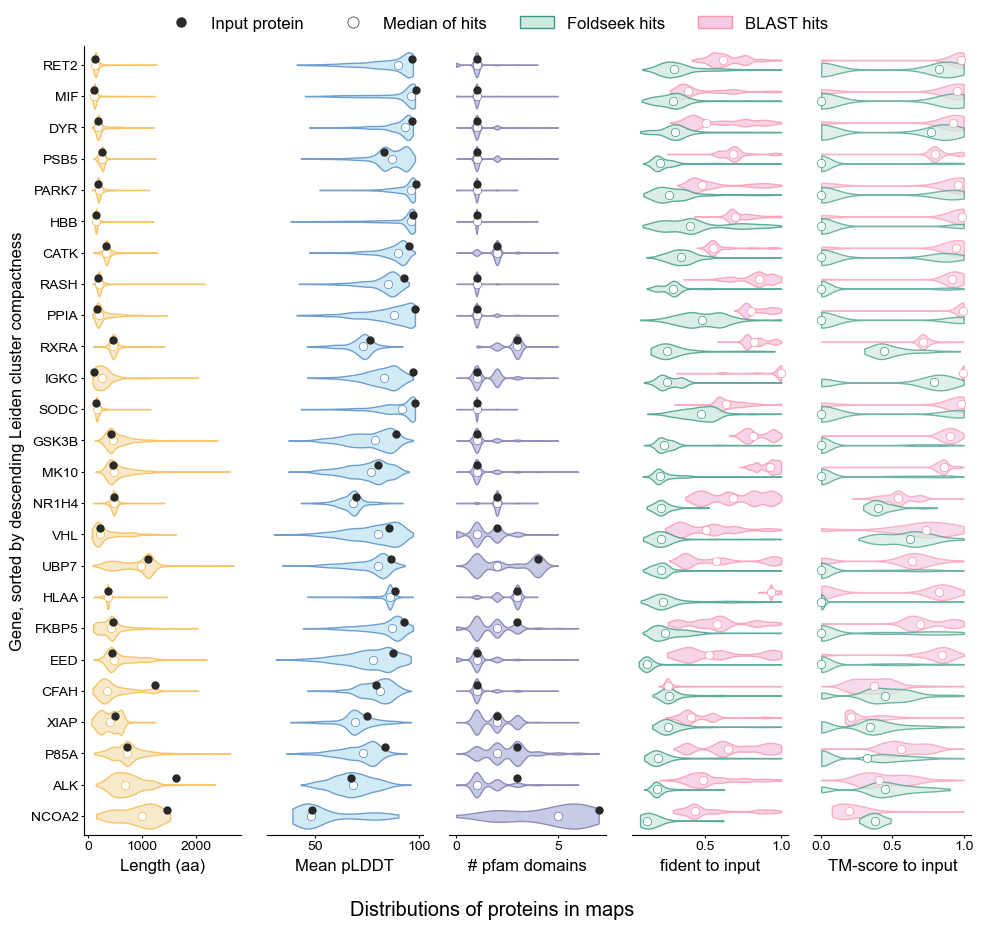

In [9]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows = 1, ncols = 5, figsize = (10, 9))
fig.subplots_adjust(wspace = 0.1)

line_length = 0.35
median_point = 1
ypos = [i + median_point for i in range(len(len_df))]
ymins = [i + median_point - line_length for i in range(len(len_df))]
ymaxs = [i + median_point + line_length for i in range(len(len_df))]

parts = ax1.violinplot(lengths_list, vert = False, showextrema = False, widths = 0.8)

for pc in parts['bodies']:
    pc.set_facecolor(apc.All['arcadia:oat'])
    pc.set_edgecolor(apc.All['arcadia:canary'])
    pc.set_linewidths(1)
    pc.set_alpha(0.8)

ax1.scatter(x = len_df['Length'].values, y = [i + 1.2 for i in range(len(len_df))], color = 'arcadia:crow', zorder = 10)
#ax1.scatter(x = lengths_mean_list, y = [i + 1 for i in range(len(len_df))], color = 'arcadia:crow', linewidth = 1, marker = 'x', zorder = 9)

#ax1.vlines(x = lengths_median_list, ymin = ymins, ymax = ymaxs, color = 'arcadia:canary')
ax1.scatter(x = lengths_median_list, y = ypos, color = 'w', edgecolor = 'arcadia:canary', linewidth = 0.5, marker = "o")

ax1.set_yticks([i + 1 for i in range(len(len_df))])
ax1.set_yticklabels(lens)
ax1.set_ylim(0.4, 25.6)
ax1.set_xlabel('Length (aa)')
ax1.set_ylabel('Gene, sorted by descending Leiden cluster compactness')

parts = ax2.violinplot(pdb_confidence_list, vert = False, showextrema = False, widths = 0.8)

for pc in parts['bodies']:
    pc.set_facecolor(apc.All['arcadia:bluesky'])
    pc.set_edgecolor(apc.All['arcadia:aegean'])
    pc.set_linewidths(1)
    pc.set_alpha(0.8)

ax2.scatter(x = len_df['pdb_confidence'].values, y = [i + 1.2 for i in range(len(len_df))], color = 'arcadia:crow', zorder = 10)

#ax2.vlines(x = pdb_confidence_median_list, ymin = ymins, ymax = ymaxs, color = 'arcadia:aegean')
ax2.scatter(x = pdb_confidence_median_list, y = ypos, color = 'w', edgecolor = 'arcadia:aegean', linewidth = 0.5, marker = "o")

ax2.set_yticks([])
ax2.spines[['left']].set_visible(False)
ax2.set_ylim(0.4, 25.6)
ax2.set_xlabel('Mean pLDDT')

parts = ax3.violinplot(ndomains_list, vert = False, showextrema = False, widths = 0.8)

for pc in parts['bodies']:
    pc.set_facecolor(apc.All['arcadia:wish'])
    pc.set_edgecolor(apc.All['arcadia:aster'])
    pc.set_linewidths(1)
    pc.set_alpha(0.8)

ax3.scatter(x = ndomains_prot_list, y = [i + 1.2 for i in range(len(len_df))], color = 'arcadia:crow', zorder = 10)

#ax3.vlines(x = ndomains_median_list, ymin = ymins, ymax = ymaxs, color = 'arcadia:aster')
ax3.scatter(x = ndomains_median_list, y = ypos, color = 'w', edgecolor = 'arcadia:aster', linewidth = 0.5, marker = "o")

ax3.set_yticks([])
ax3.spines[['left']].set_visible(False)
ax3.set_ylim(0.4, 25.6)
ax3.set_xlabel('# pfam domains')

######

median_point1 = 1.15
median_point2 = 0.85

ypos1 = [i + median_point1 for i in range(len(len_df))]
ypos2 = [i + median_point2 for i in range(len(len_df))]

ymins1 = [i + median_point1 - line_length for i in range(len(len_df))]
ymaxs1 = [i + median_point1 + line_length for i in range(len(len_df))]

ymins2 = [i + median_point2 - line_length for i in range(len(len_df))]
ymaxs2 = [i + median_point2 + line_length for i in range(len(len_df))]

parts = ax4.violinplot(fident_blast_list, positions = ypos1, vert = False, showextrema = False, widths = 0.5)

for pc in parts['bodies']:
    pc.set_facecolor(apc.All['arcadia:blossom'])
    pc.set_edgecolor(apc.All['arcadia:rose'])
    pc.set_linewidths(1)
    pc.set_alpha(0.8)

parts = ax4.violinplot(fident_fs_list, positions = ypos2, vert = False, showextrema = False, widths = 0.5)

for pc in parts['bodies']:
    pc.set_facecolor(apc.All['arcadia:mint'])
    pc.set_edgecolor(apc.All['arcadia:seaweed'])
    pc.set_linewidths(1)
    pc.set_alpha(0.8)

#ax4.vlines(x = fident_blast_median_list, ymin = ymins1, ymax = ymaxs1, color = 'arcadia:rose')
#ax4.vlines(x = fident_fs_median_list, ymin = ymins2, ymax = ymaxs2, color = 'arcadia:seaweed')

ax4.scatter(x = fident_blast_median_list, y = ypos1, color = 'w', edgecolor = 'arcadia:rose', linewidth = 0.5, marker = "o")
ax4.scatter(x = fident_fs_median_list, y = ypos2, color = 'w', edgecolor = 'arcadia:seaweed', linewidth = 0.5, marker = "o")

ax4.set_yticks([])
ax4.spines[['left']].set_visible(False)
ax4.set_ylim(0.4, 25.6)
ax4.set_xlabel('fident to input')

######

parts = ax5.violinplot(tmscore_blast_list, positions = ypos1, vert = False, showextrema = False, widths = 0.5)

for pc in parts['bodies']:
    pc.set_facecolor(apc.All['arcadia:blossom'])
    pc.set_edgecolor(apc.All['arcadia:rose'])
    pc.set_linewidths(1)
    pc.set_alpha(0.7)
    
parts = ax5.violinplot(tmscore_fs_list,  positions = ypos2, vert = False, showextrema = False, widths = 0.5)

for pc in parts['bodies']:
    pc.set_facecolor(apc.All['arcadia:mint'])
    pc.set_edgecolor(apc.All['arcadia:seaweed'])
    pc.set_linewidths(1)
    pc.set_alpha(0.7)

#ax5.vlines(x = tmscore_blast_median_list, ymin = ymins1, ymax = ymaxs1, color = 'arcadia:rose')
#ax5.vlines(x = tmscore_fs_median_list, ymin = ymins2, ymax = ymaxs2, color = 'arcadia:seaweed')

ax5.scatter(x = tmscore_blast_median_list, y = ypos1, color = 'w', edgecolor = 'arcadia:rose', linewidth = 0.5, marker = "o")
ax5.scatter(x = tmscore_fs_median_list, y = ypos2, color = 'w', edgecolor = 'arcadia:seaweed', linewidth = 0.5, marker = "o")

ax5.set_yticks([])
ax5.spines[['left']].set_visible(False)
ax5.set_ylim(0.4, 25.6)
ax5.set_xlabel('TM-score to input')

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

legend_elements = [Line2D([0], [0], marker='.', markerfacecolor='arcadia:crow', markersize=15, linewidth = 0, label='Input protein'),
                   Line2D([0], [0], marker='o', markerfacecolor='w', markeredgecolor = 'arcadia:crow', markersize=8, markeredgewidth = 0.5, linewidth = 0, label='Median of hits'),
                   Patch(facecolor = 'arcadia:mint', edgecolor='arcadia:seaweed', linewidth = 1, label='Foldseek hits'),
                   Patch(facecolor = 'arcadia:blossom', edgecolor='arcadia:rose', linewidth = 1, label='BLAST hits')]

fig.supxlabel('Distributions of proteins in maps')
plt.tight_layout()

ax3.legend(legend_elements, ['Input protein', 'Median of hits', 'Foldseek hits', 'BLAST hits'], loc = 'lower center', bbox_to_anchor = (0.3, 1), ncols = len(legend_elements))

plt.savefig('most_studied_proteins_hit_distributions_median.svg')
plt.show()

# 9. Generate taxonomic distribution plots

This code block generates a scatter comparing cluster compactness to the number of combined hits, the number of hits per method, and the number of species in the results. It also displays a proportional bar chart (normalized for total number of hits, shown on far right) for the broad taxonomic groups represented in the hits for each analysis.

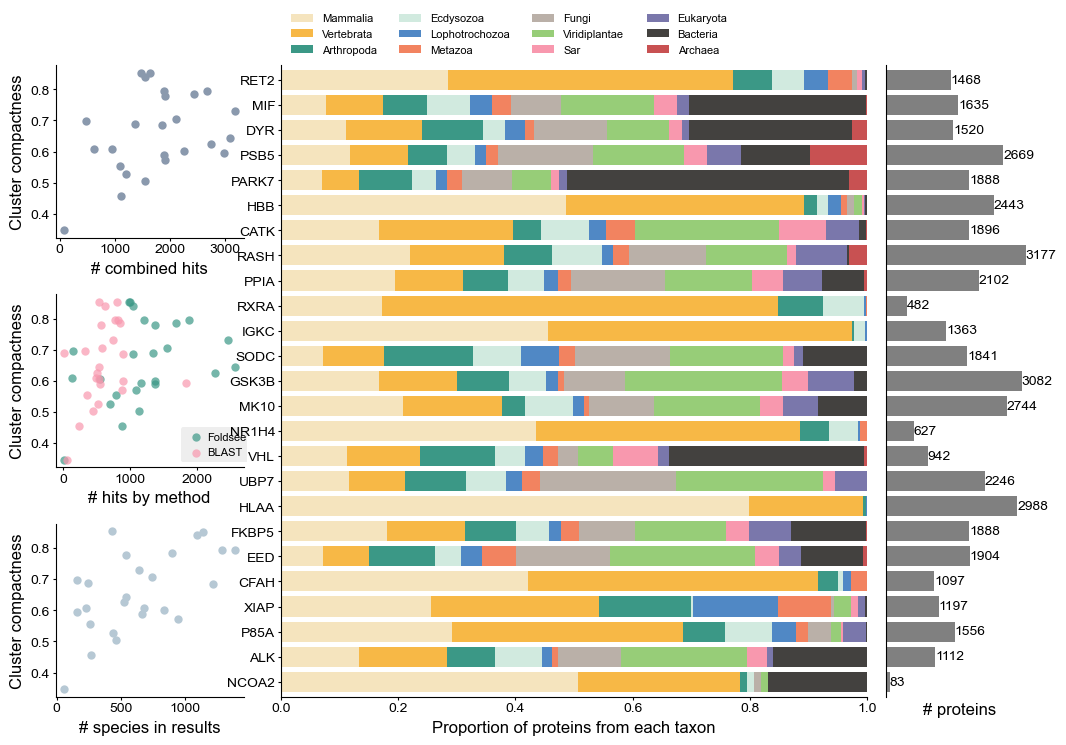

In [10]:
taxon_counts_df = pd.DataFrame(taxon_counts_dict).T.fillna(0)
taxon_counts_df = taxon_counts_df[[i for i in EUK_COLOR_DICT.keys() if i in taxon_counts_df.columns]]
category_names = [i for i in EUK_COLOR_DICT.keys() if i in taxon_counts_df.columns]
#display(taxon_counts_df)

def horizontal_stacked_bar_chart2(results, category_names, figsize=(10, 8), hide_labels=True):
    """
    Parameters
    ----------
    results : pandas DataFrame
        A DataFrame where index corresponds to question labels and columns correspond to categories.
    category_names : list of str
        The category labels.
    """
    labels = results.index
    data = results.values
    data_norm = data / data.sum(axis=1, keepdims=True)  # Normalize the data
    data_cum = data_norm.cumsum(axis=1)
    category_colors = [EUK_COLOR_DICT[name] for name in category_names]

    fig = plt.figure(figsize = figsize)
    subfigs = fig.subfigures(1, 2, wspace=0.15, width_ratios=[1, 4])
    
    ax1_l, ax2_l, ax3_l = subfigs[0].subplots(nrows = 3, ncols = 1)
    
    ax1_l.scatter(x = counts_list, y = len_df['Leiden_mean'].values, color = 'arcadia:marineblue')
    ax1_l.set_xlabel('# combined hits')
    ax1_l.set_ylabel('Cluster compactness')

    ax2_l.scatter(x = fs_counts_list, y = len_df['Leiden_mean'].values, color = 'arcadia:seaweed', alpha = 0.7, label = 'Foldseek')
    ax2_l.scatter(x = blast_counts_list, y = len_df['Leiden_mean'].values, color = 'arcadia:rose', alpha = 0.7, label = 'BLAST')
    ax2_l.set_xlabel('# hits by method')
    ax2_l.set_ylabel('Cluster compactness')
    ax2_l.legend(loc = 'lower right', fontsize = 8, facecolor = 'arcadia:brightgrey', bbox_to_anchor = (1.1, 0), handletextpad = 0)
    
    ax3_l.scatter(x = nspecies_list, y = len_df['Leiden_mean'].values, color = 'arcadia:denim')
    ax3_l.set_xlabel('# species in results')
    ax3_l.set_ylabel('Cluster compactness')

    ax1, ax2 = subfigs[1].subplots(nrows = 1, ncols = 2, gridspec_kw={'width_ratios': [4, 1]})  # Adjust the width ratio here
    subfigs[1].subplots_adjust(wspace = -0.05)
    ax1.invert_yaxis()
    ax1.set_xlim(0, 1)  # Normalized x-axis
    ax1.set_ylim(-0.6, 24.6)
    ax1.set_xlabel('Proportion of proteins from each taxon')

    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        starts = data_cum[:, i] - data_norm[:, i]  # Adjust the positions
        ax1.barh(labels, data_norm[:, i], left=starts, height=0.8,
                 label=colname, color=color, align='center')

        r, g, b, _ = mc.to_rgba(color)
        text_color = 'white' if r * g * b < 0.5 else 'darkgrey'

        if not hide_labels:
            # Display non-normalized values on top of the bars
            for j, value in enumerate(data[:, i]):
                ax1.text(data_cum[j, i] - data_norm[j, i] / 2, j, str(value), color=text_color,
                         va='center', ha='center', fontsize='small')

    ax1.legend(ncols=len(category_names) // 3, bbox_to_anchor=(0, 1),
               loc='lower left', fontsize=8)

    # Add the additional subplot on the right
    total_entries = np.sum(data, axis=1)
    ax2.barh(labels, total_entries, height=0.8, color='grey')
    for j, value in enumerate(total_entries):
        ax2.text(value, j, str(int(value)), color='black',
                 va='center', ha='left', fontsize='small')

    ax2.set_xlabel('# proteins')
    ax2.set_ylim(-0.6, 24.6)
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.spines[['bottom']].set_visible(False)

    plt.tight_layout()
    return fig, (ax1, ax2)

horizontal_stacked_bar_chart2(taxon_counts_df, category_names)

plt.savefig('most_studied_human_proteins_taxon_proportions.svg')
plt.show()